<a href="https://colab.research.google.com/github/VaggelisApostolou/auth-dws-ml-2025-final/blob/main/ML_ExerciseFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# **Data Processing**

In [37]:
train_features = pd.read_csv('/content/drive/MyDrive/ML_ExerciseFinal/train_hh_features.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/ML_ExerciseFinal/train_hh_gt.csv')
test_features = pd.read_csv('/content/drive/MyDrive/ML_ExerciseFinal/test_hh_features.csv')
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)

(104234, 88)
(104234, 3)
(103023, 88)


In [38]:
train = train_features.merge(train_labels[['hhid','cons_ppp17']], on='hhid')
print(train.shape)
train.head()

(104234, 89)


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [39]:
ID_COLS = ['hhid']
X = train.drop(columns=ID_COLS + ['cons_ppp17'])
y = train['cons_ppp17']

In [40]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns
print(len(num_cols), "numeric")
print(len(cat_cols), "categorical")

23 numeric
64 categorical


In [41]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(X_train.shape, X_val.shape)

(83387, 87) (20847, 87)


# **Data Analysis**

In [43]:
def quick_summary(df, name="df"):
    print(f"{name}: shape={df.shape}")
    display(df.head(3))
    display(df.describe(include="all").T.head(15))

In [44]:
feature_description = pd.read_csv('/content/drive/MyDrive/ML_ExerciseFinal/feature_descriptions.csv')
value_description  = pd.read_csv('/content/drive/MyDrive/ML_ExerciseFinal/feature_value_descriptions.csv')
print(feature_description.columns)
print(value_description.columns)
quick_summary(feature_description, "feature_descriptions")
quick_summary(value_description, "feature_value_descriptions")

Index(['Variable name', 'Storage type', 'Variable label'], dtype='object')
Index(['Variable name', 'Variable label', 'Value', 'Value label'], dtype='object')
feature_descriptions: shape=(108, 3)


,Variable name,Storage type,Variable label
0,sample,str8,Data Type
1,hhid,int,Household unique identifier
2,com,byte,Identifier of household member


,count,unique,top,freq
Variable name,108,108,sample,1
Storage type,108,4,byte,81
Variable label,108,108,Data Type,1


feature_value_descriptions: shape=(179, 4)


,Variable name,Variable label,Value,Value label
0,any_nonagric,Any household member working in non-agricultur...,0,No
1,any_nonagric,Any household member working in non-agricultur...,1,Yes
2,consumed100,Breads,0,No


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable name,179,64,sector1d,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variable label,179,64,Employment sector of household head (1 digit I...,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,179.0,NaN,NaN,NaN,3.22905,8.246078,0.0,0.0,1.0,3.5,99.0
Value label,179,71,No,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


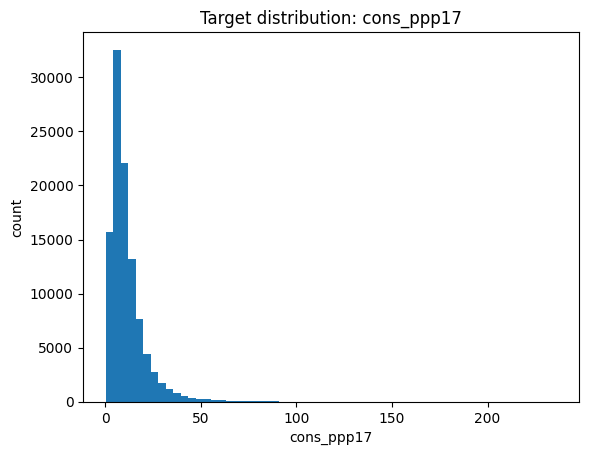

y summary:
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
1%            1.989498
5%            2.965404
25%           5.439294
50%           8.774002
75%          14.216931
99%          50.672220
max         236.115680
Name: cons_ppp17, dtype: float64


In [45]:
plt.figure()
plt.hist(y, bins=60)
plt.title("Target distribution: cons_ppp17")
plt.xlabel("cons_ppp17")
plt.ylabel("count")
plt.show()
print("y summary:")
print(y.describe(percentiles=[.01,.05,.25,.5,.75,.99]))

In [46]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns
X_num = X[num_cols].copy()
corr = X_num.corr(numeric_only=True)
corr_abs = corr.abs().where(~np.eye(corr.shape[0],dtype=bool))
top_pairs = corr_abs.unstack().sort_values(ascending=False).dropna().head(6)
print("Top 5 abs numeric correlations:")
print(top_pairs)

Top 5 abs numeric correlations:
age               num_elderly         0.615127
num_elderly       age                 0.615127
hsize             num_adult_female    0.608469
num_adult_female  hsize               0.608469
region5           strata              0.595132
strata            region5             0.595132
dtype: float64


# **Models**

In [47]:
def eval_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

In [48]:
svr = LinearSVR(C=1.0, max_iter=10000, dual='auto', random_state=42)
svr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', svr)
])
print("Training LinearSVR model (fast version)...")
svr_pipe.fit(X_train, y_train_log)
pred_svr_log = svr_pipe.predict(X_val)
pred_svr = np.expm1(pred_svr_log)
rmse_svr, mae_svr, r2_svr = eval_regression(y_val, pred_svr)
print("For LinearSVR model:")
print(f"rmse={rmse_svr:.4f}")
print(f"mae={mae_svr:.4f}")
print(f"r2={r2_svr:.4f}")

Training LinearSVR model (fast version)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


For LinearSVR model:
rmse=6.7437
mae=3.5102
r2=0.5474


In [49]:
rf = RandomForestRegressor( n_estimators=200, max_depth=20, min_samples_leaf=5,random_state=42, n_jobs=-1)
rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', rf)
])
rf_pipe.fit(X_train, y_train_log)
pred_rf_log = rf_pipe.predict(X_val)
pred_rf = np.expm1(pred_rf_log)
rmse_rf, mae_rf, r2_rf = eval_regression(y_val, pred_rf)
print("For random forest model:")
print(f"rmse={rmse_rf}")
print(f"mae={mae_rf}")
print(f"r2={r2_rf}")

For random forest model:
rmse=6.153464458145887
mae=3.3308324575010637
r2=0.6231213377950526


In [50]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)
xgb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb_model)
])
print("Training XGBoost model...")
xgb_pipe.fit(X_train, y_train_log)
pred_xgb_log = xgb_pipe.predict(X_val)
pred_xgb = np.expm1(pred_xgb_log)
rmse_xgb, mae_xgb, r2_xgb = eval_regression(y_val, pred_xgb)
print("For XGBoost model:")
print(f"rmse={rmse_xgb:.4f}")
print(f"mae={mae_xgb:.4f}")
print(f"r2={r2_xgb:.4f}")

Training XGBoost model...
For XGBoost model:
rmse=5.7616
mae=3.1268
r2=0.6696


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Deep Learning Model...
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

For Deep Learning (MLP) model:
RMSE=6.3759
MAE=3.3181
R2=0.5954


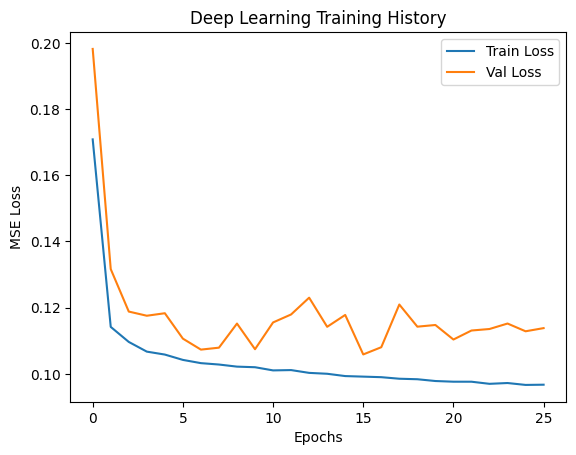

In [51]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
if hasattr(X_train_proc, "toarray"):
    X_train_dl = X_train_proc.toarray()
    X_val_dl = X_val_proc.toarray()
else:
    X_train_dl = X_train_proc
    X_val_dl = X_val_proc
input_dim = X_train_dl.shape[1]
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
dl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print("Training Deep Learning Model...")
history = dl_model.fit(
    X_train_dl, y_train_log,
    validation_data=(X_val_dl, y_val_log),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
pred_dl_log = dl_model.predict(X_val_dl).flatten()
pred_dl = np.expm1(pred_dl_log)
rmse_dl, mae_dl, r2_dl = eval_regression(y_val, pred_dl)
print("\nFor Deep Learning (MLP) model:")
print(f"RMSE={rmse_dl:.4f}")
print(f"MAE={mae_dl:.4f}")
print(f"R2={r2_dl:.4f}")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [52]:
results = pd.DataFrame({
    "Model": ["SVR", "Random Forest", "xGBoost", "Deep Learning"],
    "RMSE": [rmse_svr, rmse_rf, rmse_xgb, rmse_dl],
    "MAE": [mae_svr, mae_rf, mae_xgb, mae_dl],
    "R2": [r2_svr, r2_rf, r2_xgb, r2_dl]
})
print(results)


           Model      RMSE       MAE        R2
0            SVR  6.743722  3.510210  0.547351
1  Random Forest  6.153464  3.330832  0.623121
2        xGBoost  5.761641  3.126777  0.669589
3  Deep Learning  6.375899  3.318091  0.595382


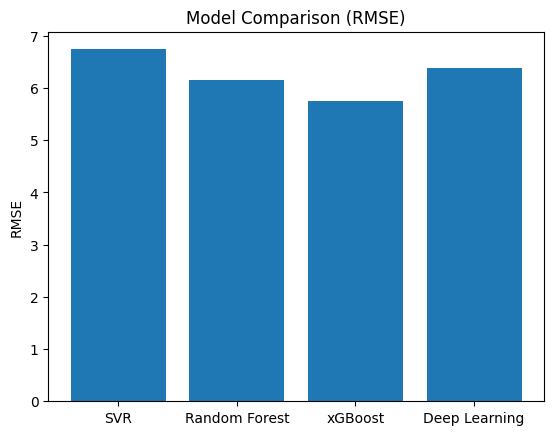

In [53]:
plt.figure()
plt.bar(results["Model"], results["RMSE"])
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()

In [54]:
param_grid = {
    "model__max_depth": [6, 10],
    "model__learning_rate": [0.03, 0.05],
    "model__max_iter": [200, 300]
}
grid = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=2,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid.fit(X_train, y_train_log)
grid.best_params_

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "max_iter" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__max_iter': 200}

# **Validation**

In [55]:
best_model = grid.best_estimator_
pred_best_log = best_model.predict(X_val)
pred_best = np.expm1(pred_best_log)
rmse_best, mae_best, r2_best = eval_regression(y_val, pred_best)
print("For gradient boosting model after fine-tuning:")
print(f"rmse={rmse_best}")
print(f"mae={mae_best}")
print(f"r2={r2_best}")

For gradient boosting model after fine-tuning:
rmse=5.80172817399467
mae=3.134701532983413
r2=0.6649752352694508


In [56]:
results = pd.DataFrame({
    "Model": ["SVR", "Random Forest", "xGBoost", "xGBoost Tuned"],
    "RMSE": [rmse_svr, rmse_rf, rmse_xgb, rmse_best],
    "MAE":  [mae_svr, mae_rf, mae_xgb, mae_best],
    "R2":   [r2_svr, r2_rf, r2_xgb, r2_best]
})

results.sort_values("RMSE")

,Model,RMSE,MAE,R2
2,xGBoost,5.761641,3.126777,0.669589
3,xGBoost Tuned,5.801728,3.134702,0.664975
1,Random Forest,6.153464,3.330832,0.623121
0,SVR,6.743722,3.510210,0.547351


In [57]:
X_full = train.drop(columns=["hhid", "cons_ppp17"])
y_full_log = np.log1p(train["cons_ppp17"])
best_model.fit(X_full, y_full_log)
X_test = test_features.drop(columns=["hhid"])
test_pred_log = best_model.predict(X_test)
test_pred = np.expm1(test_pred_log)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "max_iter" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
survey_id_test = (test_features["hhid"] // 100000) * 100000
survey_id_test.unique()

array([400000, 500000, 600000])

In [59]:
pred_household = pd.DataFrame({
    "survey_id": survey_id_test.astype(int),
    "household_id": test_features["hhid"],
    "cons_ppp17": test_pred
})
pred_household.to_csv("predicted_household_consumption.csv", index=False)

pred_household.head()

,survey_id,household_id,cons_ppp17
0,400000,400001,10.879803
1,400000,400002,6.660845
2,400000,400003,8.001488
3,400000,400004,12.424836
4,400000,400005,4.674702


In [60]:
poverty_lines = [
    3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
    9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99,
    27.37
]
poverty_rows = []
for survey_id in survey_id_test.unique():
    preds = pred_household[pred_household["survey_id"] == survey_id]
    values = preds["cons_ppp17"].values
    row = {"survey_id": survey_id}
    for p in poverty_lines:
        colname = f"pct_hh_below_{p:.2f}"
        row[colname] = (values < p).mean()
    poverty_rows.append(row)
poverty_df = pd.DataFrame(poverty_rows)
poverty_df.to_csv("predicted_poverty_distribution.csv", index=False)

In [61]:
import zipfile
with zipfile.ZipFile("submission.zip", "w") as zipf:
    zipf.write("predicted_household_consumption.csv")
    zipf.write("predicted_poverty_distribution.csv")

In [62]:
!head -n 3 predicted_household_consumption.csv

survey_id,household_id,cons_ppp17
400000,400001,10.879803
400000,400002,6.6608453


In [63]:
!head -n 2 predicted_poverty_distribution.csv

survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
400000,0.02028063069579054,0.06043685809344713,0.11320700130189498,0.17459858238102127,0.23410964848835528,0.2881816866772747,0.3353102849703457,0.3869810501952842,0.4415449153768263,0.4912194416317084,0.5387530739187039,0.5866049472009258,0.6348907854766382,0.6853464487198032,0.7393895559091567,0.7924779401128309,0.8444669463329958,0.898365398524519,0.9541154346882684
